In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 23)
(709325, 20)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
pp.get_feature_list()

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat']

In [9]:
# records of last year
#use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
#df_track = pp.dataset(feature_set=use_features, valid=True, date=('2015-10-01', '2017-10-01'))
df_track = pp.dataset(feature='delivered', valid=True, date=('2015-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(68919, 13)

In [10]:
df_track.head()

,date,num_bath,pool,sold_price_zip_avg,sqft_zip_avg,lon,view,sold_price,sqft,num_bed,lat,sqft_price_zip_avg,impr_over_land
1,2015-10-01,3.0,1,442844.453711,2074.092577,-116.87829,1,635000,2812,5.0,33.05136,221.650542,1.822222
68743,2015-10-01,3.0,0,389755.862647,1585.002513,-116.92729,0,255000,1908,3.0,32.88099,250.745394,1.469388
68199,2015-10-01,2.0,1,500043.198529,2171.954044,-116.81683,0,635000,2711,4.0,32.83643,242.273897,1.819159
21429,2015-10-01,2.0,1,520922.222222,1937.828889,-116.98197,1,925000,2833,2.0,32.76496,282.771111,0.111355
67755,2015-10-01,2.0,0,516299.549550,2605.547297,-117.00732,1,570000,2630,4.0,33.28106,209.511261,2.160035


### LinearRegression

In [19]:
# walk-forward validation
# K-fold cross validation
monthly_volume = int(df_track.shape[0] / 24)
from sklearn.linear_model import Ridge
rr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ElasticNet(random_state=42))
     ])
parameters = {'clf__l1_ratio': [0.05, 0.07, 0.1, 0.12, 0.14],
              'clf__alpha': [0.01, 0.03, 0.05, 0.07, 0.09]}

mm = ModelManager(df_track, use_features, rr, time_series=True)
mm.run(param_grid=parameters, sliding_window=monthly_volume*12, test_size=monthly_volume*4, GridSearchCV={'verbose':True, 'n_jobs':-1})

[dp] track/sliding/test window size: 57435, 34452, 11484
[dp] train/valid/test size: 45948, 11487, 11484
[dp] walk-forward train:(11487,), test:(11487,)
[dp] walk-forward train:(22974,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] 4-fold walk-forward validation
[dp] track_window:57435, sliding_window:34452, test_window:11484


Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished


174609.55013747595

In [20]:
mm.summary()

[dp] best params: {'clf__alpha': 0.01, 'clf__l1_ratio': 0.14}
[dp] best score: -29800533719.24541
[dp] cv results:
{'mean_fit_time': array([0.33927679, 0.51273865, 0.49857473, 0.55121511, 0.58969176,
       0.34867769, 0.38514906, 0.34090728, 0.35632187, 0.40520227,
       0.245152  , 0.27009356, 0.27460539, 0.25154299, 0.21933359,
       0.18085742, 0.20479423, 0.21306634, 0.18499184, 0.17960328,
       0.19464308, 0.17321092, 0.1893785 , 0.14262927, 0.08823448]),
 'mean_score_time': array([0.00250727, 0.00313383, 0.00300831, 0.00300723, 0.00338477,
       0.00288224, 0.00351   , 0.00313324, 0.00392026, 0.00325954,
       0.00313491, 0.00288343, 0.00313413, 0.00288361, 0.0027582 ,
       0.00288326, 0.00288343, 0.00275844, 0.00250655, 0.00300813,
       0.00288296, 0.00288332, 0.00263232, 0.00275731, 0.00238162]),
 'mean_test_score': array([-2.98058033e+10, -2.98046252e+10, -2.98028657e+10, -2.98016977e+10,
       -2.98005337e+10, -2.99362289e+10, -2.99315506e+10, -2.99245994e+10,
   

[dp] training error: 173985.06033448342
[dp] testing error: 174609.55013747595


## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [21]:
ntrees = np.arange(20,110,40)
depths = np.arange(7,15)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}
rf = RandomForestRegressor(n_jobs=-1, random_state=17)

mm = ModelManager(df_track, use_features, rf, time_series=True)
mm.run(param_grid=parameters, sliding_window=monthly_volume*12, test_size=monthly_volume*4, GridSearchCV={'verbose':True, 'n_jobs':-1})

[dp] track/sliding/test window size: 57435, 34452, 11484
[dp] train/valid/test size: 45948, 11487, 11484
[dp] walk-forward train:(11487,), test:(11487,)
[dp] walk-forward train:(22974,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] walk-forward train:(34452,), test:(11487,)
[dp] 4-fold walk-forward validation
[dp] track_window:57435, sliding_window:34452, test_window:11484


Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  6.9min finished


128404.15052960214

In [97]:
mm.summary()

[dp] best params: {'max_depth': 14, 'n_estimators': 180}
[dp] best score: -19300796983.746284
[dp] cv results:
{'mean_fit_time': array([ 0.59177369,  1.91336405,  3.5899924 ,  5.24094397,  6.17696816,
        1.62946939,  2.19180971,  4.27685583,  6.74678278,  8.04352015,
        2.06010449,  2.58885223,  4.50717264,  6.59861106,  7.78756279,
        1.83501834,  2.74885428,  4.66350955,  7.00448108,  8.60343587,
        2.00480115,  3.16285372,  5.16490126,  7.76854259,  9.59994435,
        2.2750023 ,  3.3574881 ,  6.29672205,  9.36377293, 10.7073428 ,
        2.74375927,  3.54890674,  6.8911525 ,  9.84457093, 11.28224498,
        2.64649737,  3.92839843,  6.93399298, 12.0612421 , 11.5269016 ]),
 'mean_score_time': array([0.23634017, 0.52748328, 0.78010058, 0.90211207, 0.74321097,
       0.98402429, 0.75692898, 1.07483059, 1.42489123, 1.27999067,
       0.9507612 , 0.65949583, 0.95409769, 1.2216177 , 1.10250288,
       0.92231977, 0.70647353, 1.06330866, 1.21055359, 1.11205345,
     

[dp] training error: 104669.76450750628
[dp] testing error: 144072.4332906728


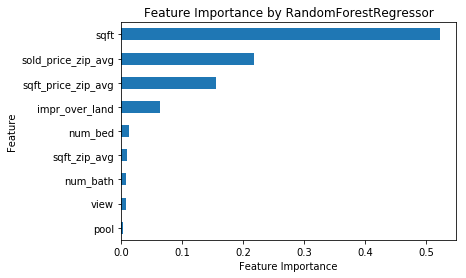

In [22]:
mm.plot_feature_importance()

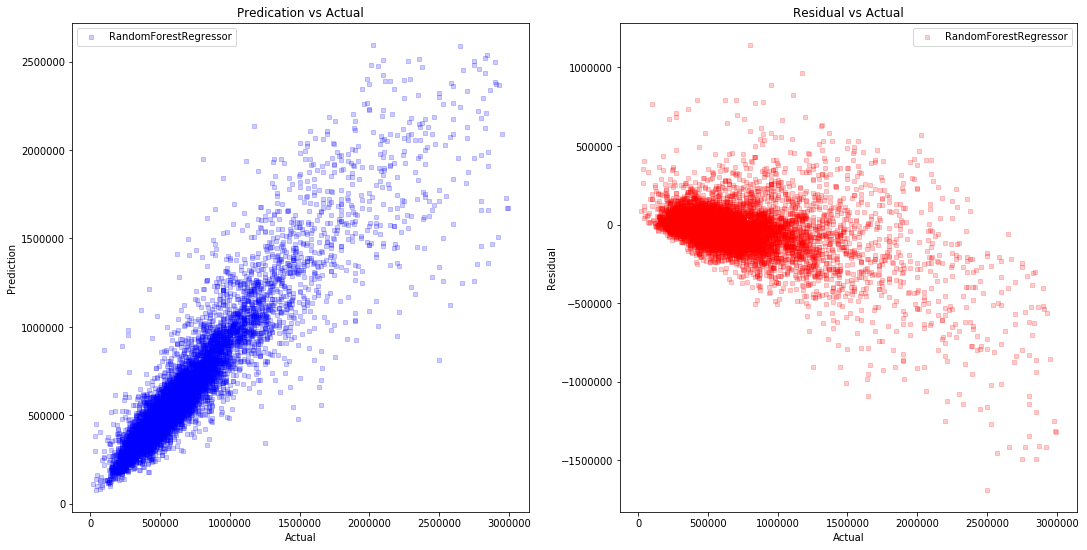

In [23]:
mm.plot_residual()

C:\Users\wenyan\Anaconda3\envs\cap\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


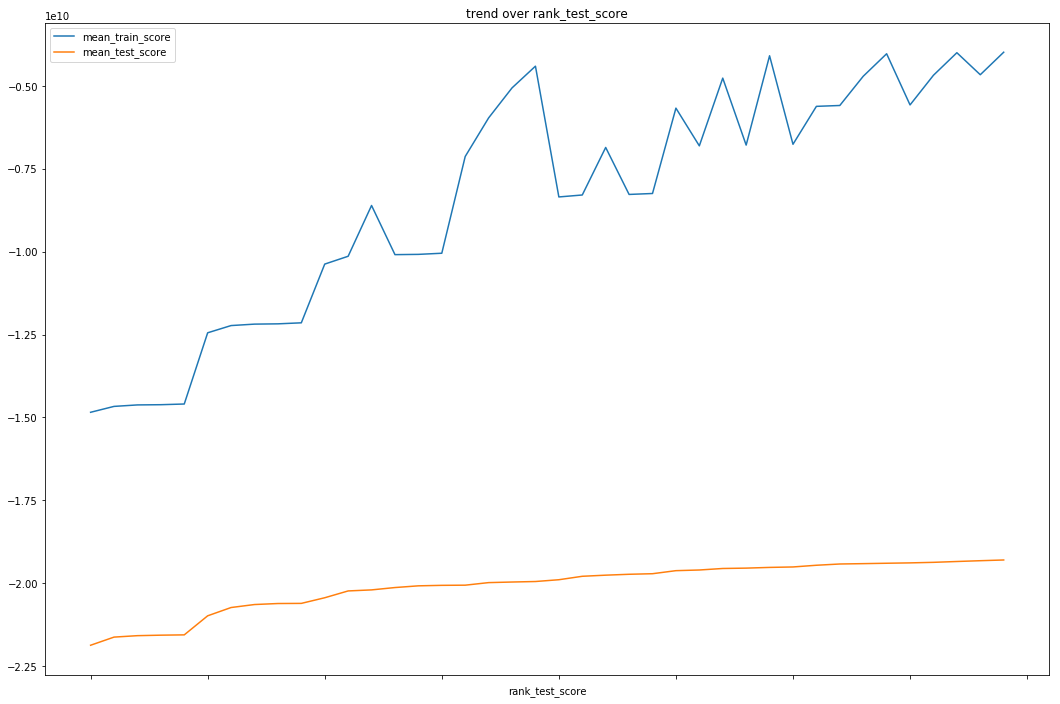

[{'max_depth': 7, 'n_estimators': 20},
 {'max_depth': 7, 'n_estimators': 60},
 {'max_depth': 7, 'n_estimators': 100},
 {'max_depth': 7, 'n_estimators': 140},
 {'max_depth': 7, 'n_estimators': 180},
 {'max_depth': 8, 'n_estimators': 20},
 {'max_depth': 8, 'n_estimators': 60},
 {'max_depth': 8, 'n_estimators': 100},
 {'max_depth': 8, 'n_estimators': 140},
 {'max_depth': 8, 'n_estimators': 180},
 {'max_depth': 9, 'n_estimators': 20},
 {'max_depth': 9, 'n_estimators': 60},
 {'max_depth': 10, 'n_estimators': 20},
 {'max_depth': 9, 'n_estimators': 100},
 {'max_depth': 9, 'n_estimators': 140},
 {'max_depth': 9, 'n_estimators': 180},
 {'max_depth': 11, 'n_estimators': 20},
 {'max_depth': 12, 'n_estimators': 20},
 {'max_depth': 13, 'n_estimators': 20},
 {'max_depth': 14, 'n_estimators': 20},
 {'max_depth': 10, 'n_estimators': 60},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 11, 'n_estimators': 60},
 {'max_depth': 10, 'n_estimators': 140},
 {'max_depth': 10, 'n_estimators': 180},
 {'

In [99]:
mm.plot_learning_curve()